# Time Dependent Vehicle Routing Problem

In [1]:
import osmnx as ox
import requests
import json
import networkx as nx
import folium
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore");

__Downloading and saving the detailed road information of the desired region with Osmnx via OpenStreetMap.__

In [2]:
try:
    G = ox.load_graphml('fatihfullwalk.graphml')
    print('GraphML was read from file and Graph was created.')
except:
    G = ox.graph_from_place('Fatih, Istanbul, Turkey', network_type='walk')
    ox.save_graphml(G, filepath='fatihfullwalk.graphml')
    print("Graph Saved")
    G = ox.load_graphml('fatihfullwalk.graphml')
    print('GraphML was read from file and Graph was created.')

GraphML was read from file and Graph was created.


__Visualization of the created graph on the map. In the image below, you can see the connections of the streets and avenues of the selected region.__

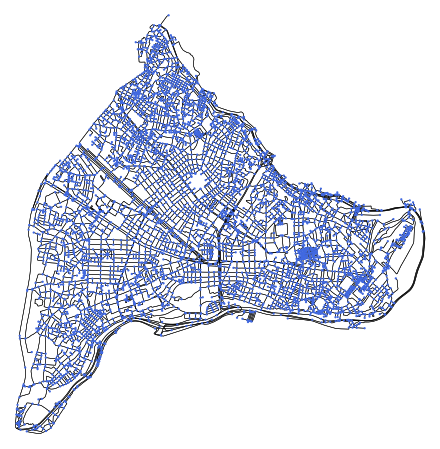

In [3]:
ox.plot_graph(G,edge_linewidth=0.5, bgcolor='#FFFFFF', node_color='#4169e1', edge_color='#000000', node_size=5);

__Map information was taken with the overpass query.__

In [4]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Fatih"]->.a;
(
  node["tourism"~"viewpoint|theme_park|museum"]["name"](area.a);
  node["historic"~"."]["name"](area.a);
  node["natural"~"."]["name"](area.a);
);

out center;                                                                                                                       
"""

response = requests.get(overpass_url,params={'data': overpass_query})
data = response.json()

with open('fatih.json', 'w') as outfile:
    json.dump(data, outfile)
    print("POI list was written.")

__The downloaded information was read from the file.__

In [5]:
with open('fatih.json', 'r') as f:
    data = json.load(f)
    print("POI list was read.")

POI list was read.


In [6]:
#Information about all places read from the file.
all_places = [element for element in data['elements']]
print("Number of places: " + str(len(all_places)))

Number of places: 74


### Adding a Start Point

__This time, let's take the informations about the chosen starting point by adding the "overpass" library. Next, we took the required coordinate and name information from it and added it to the start of the list.__

In [7]:
import overpass
api = overpass.API()
resp = api.get('node["name"="Fatih Belediyesi"]')

lat, lon = resp["features"][0]["geometry"]["coordinates"][1], resp["features"][0]["geometry"]["coordinates"][0]
name = resp["features"][0]["properties"]["name"]
depot = {"lat":lat, "lon":lon, "tags":{"name":name}}

all_places.insert(0,depot)

### Distance matrix was created with Networkx and OSMNX.

In [8]:
places = []
nearest_nodes = []
for place in all_places:
    point = (place["lat"],place["lon"])

    places.append(place["tags"]["name"])

    nearest = ox.get_nearest_node(G, point, method='haversine', return_dist=False)

    nearest_node = G.nodes[nearest.copy()]

    nearest_node["name"] = place["tags"]["name"]

    nearest_nodes.append(nearest_node.copy())
    
    
distance_matrix = []
for source_node in nearest_nodes:
    distance_row = []
    for target_node in nearest_nodes:        
        distance = 0;
        if source_node['osmid'] != target_node['osmid'] and nx.has_path(G,source_node['osmid'],target_node['osmid']):
            distance = nx.shortest_path_length(G, source_node['osmid'],target_node['osmid'],weight='length', method='dijkstra')
        elif source_node['osmid'] == target_node['osmid']:
            distance = 0
        else:
            distance = np.inf
        distance_row.append(distance)
    distance_matrix.append(distance_row)
    
distance_matrix = np.array(distance_matrix)   

### Distance -> Time
* Estimated Car Speed: 40km/h  --> 667 m/min
* Estimated Bike Speed: 10km/h --> 167 m/min
* Estimated Pedestrian Speed: 4km/h --> 67 m/min

_1km/h -> 16.67meter/minutes_

In [9]:
kmh_to_meterpermin = 167 #10km/h, bike speed

time_matrix = distance_matrix/kmh_to_meterpermin
places = np.array(places)

In [10]:
def create_environment(time_matrix, cities, eps = 0.0001):
    N =len(cities)

    def pheremon_matrix(cities, eps = eps):
        N =len(cities)
        data = (np.ones((N,N))- np.eye(N)) /(N-1)
        
        phe = pd.DataFrame(data=data, columns = cities, index = cities)
        
        return phe.loc[~phe.index.duplicated(),~phe.columns.duplicated()]
    env = pd.DataFrame(time_matrix, columns = cities, index = cities)
    
    return env.loc[~env.index.duplicated(),~env.columns.duplicated()], pheremon_matrix(cities)

env, phe = create_environment(time_matrix = time_matrix, cities = places)

### Data preparation section has finished.

## Ant Class

In [11]:
class Ant():
    def __init__(self, env, phe, 
                 start = nearest_nodes[0]['name'],
                alpha = 1, beta = 1, time_constraint = 600, time_spent = 30):
        
        self.outliers = []
        self.time_constraint = time_constraint
        self.time_spent = time_spent
        
        self.phe  = phe
        self.env = self.outlier(env)
        
        self.alpha, self.beta = alpha, beta
        self.cities = list(self.env.columns)
        self.current_city = start
        self.depot = start
        
        self.route = [self.current_city]
  
        self.possible_cities = self.cities.copy()
        self.possible_cities.remove(self.current_city)
        
    @staticmethod    
    def cost(route, time_spent,en):
        result = 0
        for i in range(len(route)-1):
            result += en.loc[route[i], route[i+1]]
        result+= en.loc[route[len(route)-1],route[0]] + (len(route)-2)*time_spent

        return result
        
    def move(self):
        """
        Move one step
        """

        if len(self.possible_cities) == 0:
            return

        distances = self.env.loc[self.current_city][self.possible_cities]
        pheremons = self.phe.loc[self.current_city][self.possible_cities]
        
        distances[distances == 0] = 1
        
        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        probabilities.dropna(inplace=True)
        
        self.current_city = np.random.choice(a = probabilities.index, 
                                             size=1, 
                                             p = probabilities.values)[0]

        self.route.append(self.current_city)
        self.possible_cities.remove(self.current_city)
        
        
        temp_route = np.array(self.route)
        current_depot = np.where(temp_route == self.depot)[0][-1]

        cnt = Ant.cost(self.route[current_depot:], self.time_spent, self.env)

        if cnt > self.time_constraint:

            self.route.pop()
            self.possible_cities.append(self.current_city)
           
            cnt = Ant.cost(self.route[current_depot:], self.time_spent, self.env)
            
            if cnt < self.time_constraint:
                self.route.append(self.depot)
                self.current_city = self.depot    
            else:
                return
                
                      
    def go(self):
        """
        Build route/path
        """
        while len(self.possible_cities) != 0:
            self.move()


    def deposit(self):
        return self.route
 
    # Outlier is mean there is no way or it is too far to go within the specified time.    
    def outlier(self, en):       
        control = []       
        for i,_ in enumerate(en.index.values):
            cost_temp = Ant.cost([en.index[0],en.index[i]], self.time_spent,en)
            if type(cost_temp) == pd.core.series.Series:
                control.append(cost_temp[0])
            else:
                control.append(cost_temp)
            
        control_np = np.array(control)
        
        out = en.index.values[control_np>self.time_constraint]
        
        self.outliers.append(out)
               
        en = en.drop(out, axis=1)    
        en = en.drop(out, axis=0)
        
        return en

## Ant Colony Class

In [12]:
class AntColony():
    def __init__(self, time_matrix,
                 cities, start = nearest_nodes[0]['name'], time_constraint = 600, time_spent = 30):
        
        self.cities = cities
        self.start = start  
        self.env, self.phe = create_environment(time_matrix, cities = cities)
        self.time_constraint = time_constraint
        self.time_spent = time_spent

    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        self.phe = self.phe * (1 - decay)
        
    def deposit(self, route, delta = 1):
        self.env[self.env == 0] = 10**-6
        for i,j in zip(route[:-1], route[1:]):
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j]
        
    def run(self, K = 40, time = 10):
        # in each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [Ant(env = self.env, phe = self.phe, 
                          start= self.start, alpha=1, beta=2.5, time_constraint = self.time_constraint, time_spent = self.time_spent) 
                      for k in range(K)]

            # distributed and paralel moves of K ants
            for k in range(K):
                self.colony[k].go()   

            # after independent moves, ants deposit pheremon
            for k in range(K):
                path = self.colony[k].deposit()
                self.deposit(route = path)
                
            self.evaporation()

## TDVRP Class

In [13]:
class TimeDepentendVRP():
    def __init__(self, Swarm, K, Time):
        
        self.swarm = Swarm       
        self.swarm.run(K,Time)
        
    def getSwarm(self):
        return self.swarm
        
        
    def printDetails(self, routes, routes_cost, outliers):
        count = 1
        for a,i in zip(routes,routes_cost):
            print("Vehicle " + str(count) + ": " + str(a) + " = " + str(round(i,3)) + " Minutes", end='\n\n')
            count+=1
        print("Total Time: " + str(round(np.sum(routes_cost),3)) + " Minutes", end='\n\n')
        print("Outliers: " + str(outliers))
        
        
    def getResult(self, getAsDataFrame = True):
        results_dist = [Ant.cost(a.route, a.time_spent, a.env) for a in self.swarm.colony]
        
        min_result_index = np.argmin(results_dist)
       
        best_routes = np.array(self.swarm.colony[min_result_index].route)

        outliers = np.array(self.swarm.colony[min_result_index].outliers[0])
        start = self.swarm.colony[min_result_index].depot


        depot_points = np.where(best_routes == self.swarm.start)[0] 

        
        route_ranges = [range(depot_points[i],depot_points[i+1]) for i in range(len(depot_points)-1)]
       
        
        route_ranges.append(range(depot_points[-1],len(best_routes)))
        
        routes = [best_routes[route_ranges[i]].tolist() for i in range(len(route_ranges))]
        
        [routes[i].append(start) for i in range(len(routes))]
        
        routes_cost = [Ant.cost(routes[i][:-1], self.swarm.colony[min_result_index].time_spent, self.swarm.colony[min_result_index].env) for i in range(len(routes))]
        
        self.printDetails(routes, routes_cost, outliers)
        
        if getAsDataFrame == True:
            return pd.DataFrame([routes, routes_cost]).T

In [14]:
daily_limit_of_work = 200 #60min x 10hour
time_spent = 10
swarm = AntColony(time_matrix, cities = places, start = nearest_nodes[0]['name'], time_constraint = daily_limit_of_work, time_spent = time_spent)

VRP = TimeDepentendVRP(swarm, 40, 10)
df = VRP.getResult()

Vehicle 1: ['Fatih Belediyesi', 'Fatih Sultan Mehmet Anıtı', 'Kaligaria gate', 'İvaz Efendi Çeşmesi', 'Ebuzer Gifari Türbesi', 'Rezan Has Museum', 'Zeyrek Sarnıcı', 'Hava Şehitleri Anıtı', 'Kıztaşı', 'Ayios Polieuktos Kilisesi', 'Fatih Anıtı', 'Mozaic hotel', 'نركيلة', 'İstanbul’un Orta Noktası', 'Molla Hüsrev cami Turbası', 'Fatih Belediyesi'] = 197.144 Minutes

Vehicle 2: ['Fatih Belediyesi', 'Milyon Taşı', 'Yerebatan Sarnıcı', 'Ayasofya Müzesi', 'Sultan Ahmet Vakti', 'Halı Müzesi', 'القصطنيطنية', 'Magnaura Sarayı', 'Büyük Saray Mozaikleri Müzesi', 'Theodosius Dikilitaşı', 'Yılanlı Sütun', 'Örme Dikilitaş', 'Marmara Üniversitesi Cumhuriyet Müzesi ve Sanat Galerisi', 'İstanbul Cumhuriyet Eğitim Müzesi', 'Fatih Belediyesi'] = 189.202 Minutes

Vehicle 3: ['Fatih Belediyesi', 'Zindan baba Türbesi', 'Manifaturaci Draper', 'Hamal', 'Tasciri Spettacolo', 'Hodjapasta', 'Atatürk', 'İstanbul Demiryolu Müzesi', 'Sepetçiler Kasrı', 'Sarayburnu Atatürk Anıtı', 'Sarayburnu Manzarası', 'Turgut Reis

## Let's visualize the results on the map.

In [15]:
#Names have been converted to indices, to be displayed on the map.
def name_to_index(df,places):
    solution_routes = []
    for a in df[0]:
        df_np = np.array(a[:-1]).copy()
        solution_route = []
        for i in df_np:

            list_place = np.where(places == i)[0]
            if len(list_place) == 1:
                solution_route.append(list_place[0])
            elif len(list_place) > 1:
                splits = np.split(list_place,len(list_place))
                for u in splits:
                    solution_route.append(u.tolist()[0])
        solution_routes.append(solution_route.copy())

    return solution_routes
        
solution_routes = name_to_index(df,places)

In [16]:
# Different colors for different routes.
def get_route_color(index):
    colors = ['#FF0000','#0000FF','#008000','#800080','#FFA500','#8B0000','#FFCCCB','#F5F5DC','#00008B','#006400','#5F9EA0',
              '#4B0082','#FFC0CB','#ADD8E6','#20B2AA','#808080','#D3D3D3']
    return colors[index%len(colors)]

# Different colors for different nodes.
def get_icon_color(index):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray']
    return colors[index%len(colors)]

In [17]:
coords_median = np.median([(nearest_nodes[index]["y"], nearest_nodes[index]["x"]) for index in range(len(nearest_nodes))],axis=0)

m = folium.Map(location=coords_median.tolist())

route_color = 0
for solution_route in solution_routes:
    order = 0
    for index in solution_route:
        if order == 0:
            popup_title = '<h3><strong>'+ "Depot:" +'</strong> '+str(nearest_nodes[index]["name"])+'</h3>'
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title,tooltip=tooltip,icon=folium.Icon(color='black')).add_to(m)
        else:
            popup_title = '<h3><strong>' +"Route "  + str(route_color+1) + " - Order " +str(order)+':</strong> '+str(nearest_nodes[index]["name"])+'</h3>'
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title,tooltip=tooltip,icon=folium.Icon(color=get_icon_color(route_color))).add_to(m)
               
        order += 1

    counter = 0
    while counter < len(solution_route)-1:
        source_index = solution_route[counter];
        target_index = solution_route[counter+1];
        
        if nearest_nodes[source_index]['osmid'] != nearest_nodes[target_index]['osmid']:
            route = nx.shortest_path(G, nearest_nodes[source_index]['osmid'],nearest_nodes[target_index]['osmid'])
            m = ox.plot_route_folium(G, route, route_map=m, popup_attribute='length', fit_bounds=True,route_color=get_route_color(route_color),route_opacity=0.7)

        counter+=1
    route_color+=1


m.save('Routes.html')
print("The map was created and saved as Routes.html.")

Harita oluşturuldu. Routes.html olarak kaydedildi.


In [18]:
from IPython.display import display
display(m)

## Sources

Data Preparation with Overpass, OSMNX -> https://github.com/eyildiz/osmnx-route-planner/blob/master/route_planner.ipynb

ACO, Uzay Çetin -> https://github.com/uzay00/CMPE373/blob/master/2020/3%20KarincaKolonisi/KarincaKolonisiv4.ipynb